## Siamese Neural Networks 
### for Supervised Clustering of High Dimensional Spaces

In [1]:
!python -V
!which python

Python 3.8.5
/Users/seanmacrae/mobius/.venv/bin/python


In [2]:
import pandas as pd

from loaderbot.big_query import query_table_and_cache
from google.cloud import bigquery

sql = """WITH matches AS (
    SELECT DISTINCT
        account_id,
        windfall_id ,
        candidate_id,
        confidence,
        CASE 
         -- luxury
         WHEN account_id = 81 THEN "1stDibs"
         WHEN account_id = 614 THEN "TamaraMellon"
         WHEN account_id = 585 THEN "Tonal"
         -- WHEN account_id = 385 THEN "WheelsUp"
         -- WHEN account_id = 208 THEN "Inspirato"
         -- WHEN account_id = 1577 THEN "OneFlight"
         -- alternative investment
         -- WHEN account_id = 501 THEN "Cadre"
         -- WHEN account_id = 679 THEN "Crowdstreet"
         -- WHEN account_id = 1047 THEN "Equaim"
         -- WHEN account_id = 1218 THEN "EquityEstates"
         -- WHEN account_id = 1246 THEN "EquityMultiple"
         WHEN account_id = 1050 THEN "MasterWorks"
         WHEN account_id = 753 THEN "Microventures"
         -- WHEN account_id = 1473 THEN "Portfolia"        
         -- insurance
         -- WHEN account_id = 514 THEN "HealthIQ"
         -- WHEN account_id = 1344 THEN "PureInsurance"
         -- finance
         -- WHEN account_id = 1219 THEN "SmartBiz"
         -- health
         -- WHEN account_id = 220 THEN "GrandViewHealth"
         -- WHEN account_id = 352 THEN "NewEnglandBaptistHospital"
         -- WHEN account_id = 1216 THEN "NuvanceHealth"
         -- WHEN account_id = 654 THEN "ProvidenceHealth"
         -- WHEN account_id = 1197 THEN "StCharles"
         END AS account_name,
         CASE 
         -- luxury
         WHEN account_id = 81 THEN "lux"
         WHEN account_id = 614 THEN "lux"
         WHEN account_id = 585 THEN "lux"
         -- WHEN account_id = 385 THEN "lux"
         -- WHEN account_id = 208 THEN "lux"
         -- WHEN account_id = 1577 THEN "lux"
         -- alternative investment
         -- WHEN account_id = 501 THEN "alt"
         -- WHEN account_id = 679 THEN "alt"
         -- WHEN account_id = 1047 THEN "alt"
         -- WHEN account_id = 1218 THEN "alt"
         -- WHEN account_id = 1246 THEN "alt"
         WHEN account_id = 1050 THEN "alt"
         WHEN account_id = 753 THEN "alt"
         -- WHEN account_id = 1473 THEN "alt"
         -- insurance
         -- WHEN account_id = 514 THEN "insurance"
         -- WHEN account_id = 1344 THEN "insurance"
         -- finance
         -- WHEN account_id = 1219 THEN "finance"
         -- health
         -- WHEN account_id = 220 THEN "health-donor"
         -- WHEN account_id = 352 THEN "health-donor"
         -- WHEN account_id = 1216 THEN "health-donor"
         -- WHEN account_id = 654 THEN "health-donor"
         -- WHEN account_id = 1197 THEN "health-donor"
         END AS label,
    FROM `portal.match`
    )

SELECT
    m.label,
    audience.*,
    latest.city,
    latest.state,
    latest.zipcode,
    latest.county,
    latest.metroName,
    realEstateInvestor,
    personalInvestor,
    FROM
    `tranquil-garage-139216.people.audience_latest` audience
    LEFT JOIN `tranquil-garage-139216.people.audience_dbusa_features` dbusa using(id)
    LEFT JOIN `tranquil-garage-139216.people.latest` latest ON latest.id = audience.id
    LEFT JOIN matches m ON audience.id = m.windfall_id
    WHERE m.label IS NOT NULL
    AND m.confidence > 0.90
    """

In [3]:
sql = """
WITH matches AS (
    SELECT DISTINCT
        account_id,
        windfall_id ,
        candidate_id,
        confidence
    FROM `portal.match`),
    
# TODO: add employment features


accounts_opps as (
            select distinct
                a.Id as account_id,
                a.Member_Number__c as member_id,
                cast(PARSE_DATETIME("%Y-%m-%d", CloseDate) as date) as close_date,
                cast(Total_Purchase_Price_Fund_Program__c as float64) as fund_amount,
                case
                    when a.Member_Account_Type__c = 'Connect' then 'Connect'
                    when a.Member_Account_Type__c = 'Individual' then 'Core'
                    else 'Others'
                end as membership_type,
                cast(PARSE_DATETIME("%Y-%m-%d", Member_Start_Date__c) as date) as member_start_date
            from `wheelsup.sfdc_account` a
            left join `wheelsup.sfdc_opportunity` o on o.AccountId = a.Id
            where True
                and o.StageName = 'Closed Won'
                and a.Member_Account_Type__c in ('Individual', 'Connect')
                and a.IsDeleted = 'false'
                and o.IsDeleted = 'false'
                and a.Member_Number__c is not null
        )
        ,
        agg_funds as (
            select
                member_id,
                account_id,
                membership_type,
                sum(fund_amount) as total_funds,
                case
                    when sum(fund_amount) > 0 then True
                    else False
                end as is_funded
            from accounts_opps
            group by 1,2,3
        )
        ,
        wf_match as (
            select distinct
                a.*,
                c.How_Many_Private_Flights_Per_Year__c as private_flights, 
                c.id as contact_id,
                w.id as windfall_id,
                m.candidate_id as candidate_id,
                w.*,
                case
                    when w.id is not null then True
                    else False
                end as is_matched
            from agg_funds a
                left join  `wheelsup.sfdc_contact` c on  c.AccountId = a.account_id
                left join `portal.match` m on m.account_id = 385 and c.id = m.candidate_id and confidence >= 0.6
                left join `people.audience_latest` w on m.windfall_id = w.id
            where Primary_Contact__c = 'true'
        )
        ,
        dedupe_contacts as (
            with for_dedupe as (
                select *, row_number() over (partition by account_id) rn
                from wf_match
            )
            select * except (rn)
            from for_dedupe
            where rn=1
        ),

raw_data AS (
  SELECT DISTINCT
      CASE WHEN dedupe_contacts.membership_type IS NULL THEN "None" ELSE dedupe_contacts.membership_type END AS label,
      audience.* EXCEPT(recentDeathDate, recentFoundationAssociationDate, isFoundationOfficer, recentFoundationTrusteeDate, hasFoundationAssociation, hasCharityBoardMember, hasCharityOfficer,
                      isArtsCause,	isEducationCause,	isEnvironmentalCause,	isAnimalCause,	isHealthCause,	isHumanServicesCause,	isInternationalCause,	isSocialBenefitCause,	isReligiousCause,
                      isHouseholdDebt, isCharityBoardMember, isCharityOfficer, is990Donation,	isCoopDonation,	isFECContribution,	isStateContribution,
                      logMaxDonationAmount_1year,	logSumDonationAmount_1year,	logsumCOOPDonation_1year,	logsumFECDonation_1year,	logsumStateContribution_1year,	countNumCharities_1year, 
                      logMaxDonationAmount_3year,	logSumDonationAmount_3year,	logsum990Donation_3year,	logsumCOOPDonation_3year,	logsumFECDonation_3year,	logsumStateContribution_3year,	countNumCharities_3year,	
                      logMaxDonationAmount_5year,	logSumDonationAmount_5year,	logsum990Donation_5year,	logsumCOOPDonation_5year,	logsumFECDonation_5year,	logsumStateContribution_5year,	countNumCharities_5year,
                      lux_athletic, lux_flight, lux_goods, lux_travel, num_vehicles, num_luxury_vehicles, num_ultra_luxury_vehicles, num_cars, num_trucks, num_suvs, num_vans, metroRank),
      dbusa.realEstateInvestor,
      dbusa.personalInvestor,
      latest.city,
      latest.state,
      latest.zipcode,
      latest.county,
      latest.metroName,
      latest.censusPlaceFIPS,
      latest.primaryCarMake,
      latest.primaryCarModel,
      latest.isImportedCarOwner,
      latest.numberOfVehicles,
      FROM
      `tranquil-garage-139216.people.audience_latest` audience
      LEFT JOIN `tranquil-garage-139216.people.audience_dbusa_features` dbusa using(id)
      LEFT JOIN `tranquil-garage-139216.people.latest` latest ON latest.id = audience.id
      LEFT JOIN matches m ON audience.id = m.windfall_id
      LEFT JOIN dedupe_contacts ON dedupe_contacts.windfall_id = audience.id
      AND m.confidence > 0.90
      )
      
SELECT * EXCEPT(rn)
FROM (
  SELECT *,
  ROW_NUMBER() OVER(PARTITION BY label ORDER BY RAND()) AS rn
  FROM raw_data)
WHERE rn <= 7000
ORDER BY id, label
"""

In [4]:
import os
import hashlib

raw_data_name = hashlib.md5(sql.encode('utf-8')).hexdigest()

if os.path.exists(f"data/{raw_data_name}.csv"):
    raw_data = pd.read_csv(f"data/{raw_data_name}.csv")
else:
    raw_data = query_table_and_cache(sql=sql)
    raw_data.to_csv(f"data/{raw_data_name}.csv")

In [5]:
# raw_data["label"] = raw_data["membership_type"]

In [6]:
# from sklearn.model_selection import train_test_split

# df, _ = train_test_split(
#     raw_data,
#     test_size=0.980,
#     stratify=raw_data["label"])

# df.shape

In [7]:
df = raw_data.copy()

## Tabular Learner

Before we train the Tabular Siamese Learner we will train baseline Tabular Learner for species classification... (why do we do this, exactly? can we just instantiate a Tabular Siamese Learner without a baseline Tabular Learner ???)

Ah yes, to init a new `TabularSiameseModel` we need to provide an `encoder` and `head` and the Tabular Learner will act as the `encoder` we init the `TabularSiameseModel` with.

In [8]:
from sklearn.model_selection import train_test_split

df_train, df_val = train_test_split(
    df,
    test_size=0.20,
    stratify=df["label"])

df_train.shape, df_val.shape

((11600, 74), (2901, 74))

In [9]:
from fastai.tabular.all import CategoryBlock
                                
y_names = ["label"]
y_block = CategoryBlock()

In [10]:
exclude_vars = ["label", "id", "investorId", "createdAt", "investorId_1", "investorId_2",
               "investorLevel", "investorLevel_1", "status", "windfall_id", "windfall_id_1",
                "candidate_id", "minInvestmentDate", "maxInvestmentDate", "confidence", 
                "closed", "countInvestmentDate", "amount", "sumAmount", "account_id", "contact_id", 
                "membership_type", "is_matched", "Unnamed: 0", "member_id"]

In [11]:
from mobius.utils import emb_sz_rule

cat_names = [x for x in df.select_dtypes(exclude=['int', 'float']).columns if x != y_names]
cat_names = [x for x in cat_names if x not in exclude_vars]

# calc embedding sizes for each categorical feature
emb_szs = {k: emb_sz_rule(len(df[k].unique())) for k in cat_names}
emb_szs

{'city': 167,
 'state': 15,
 'county': 81,
 'metroName': 66,
 'censusPlaceFIPS': 156,
 'primaryCarMake': 14,
 'primaryCarModel': 63,
 'isImportedCarOwner': 2}

In [12]:
import numpy as np

cont_names = [x for x in df.select_dtypes([np.number]).columns if x != y_names]
cont_names = [x for x in cont_names if x not in exclude_vars]
cont_names

['logNetWorth',
 'logAccreditedNetWorth',
 'recentPurchaseDate',
 'recentDivorceDate',
 'isBoatOwner',
 'isPlaneOwner',
 'recentPhilanthropicGiftDate',
 'isMultiPropertyOwner',
 'isRentalPropertyOwner',
 'logTotalHouseholdDebt',
 'recentSecTransactionAcquired',
 'recentSecTransactionDisposed',
 'recentPoliticalContributionDate',
 'isSmallBusinessOwner',
 'primaryPropertyLoanToValue',
 'logPrimaryPropertyAvm',
 'hasTrust',
 'politicalDemocrat',
 'politicalRepublican',
 'politicalIndependent',
 'femaleCount',
 'maleCount',
 'minHouseholdAge',
 'avgHouseholdAge',
 'maxHouseholdAge',
 'metroNameRank',
 'propertyCount',
 'isSFROwner',
 'isCondoOwner',
 'isRuralResidenceOwner',
 'logMaxPropertyAvm',
 'logSumPropertyAvm',
 'maxPropertySqft',
 'maxBedrooms',
 'primaryPropertySqft',
 'primaryPropertyYearsOwned',
 'minPropertyYearsOwned',
 'maxPropertyYearsOwned',
 'logMaxDonationAmount',
 'logSumDonationAmount',
 'logsumArtsCause',
 'logsumEducationCause',
 'logsumEnvironmentalCause',
 'logsumA

In [13]:
from fastai.tabular.all import (Categorify, CategoryBlock, FillMissing, FillStrategy,
                                Normalize, TabDataLoader, TabularPandas,
                                tabular_config, tabular_learner)
# from collections import defaultdict
# from dataclasses import dataclass, field

# @dataclass
# class MyFillMissing(FillMissing):
#     fill_strategy:FillStrategy=FillStrategy.constant
#     add_col:bool=False
#     fill_vals:float=field(default_factory=dict)

# procs = [MyFillMissing, Categorify, Normalize]
procs = [FillMissing, Categorify, Normalize]

In [14]:
from fastai.data.core import range_of
from fastai.tabular.all import RandomSplitter

# train/test split
splits = RandomSplitter(valid_pct=0.20)(range_of(df))

In [15]:
tabular_pandas = TabularPandas(
        df,
        procs=procs,
        cat_names=cat_names,
        cont_names=cont_names,
        y_names=y_names,
        y_block=y_block,
        splits=splits,
        device="cpu")

In [16]:
trn_dl = TabDataLoader(
    tabular_pandas.train,
    bs=128,
    shuffle=True,
    drop_last=True,
    num_workers=2)

val_dl = TabDataLoader(
    tabular_pandas.valid,
    bs=128,
    num_workers=2)

In [17]:
from fastai.data.core import DataLoaders

dls = DataLoaders(trn_dl, val_dl)

print("Sample batch:")
# dls.one_batch()

Sample batch:


In [18]:
from fastai.metrics import F1Score, Precision, Recall, accuracy

# load the tabular_pandas data through the tabular_learner
layers = [1024, 512]

# tabular learner configuration
config = tabular_config(ps=[0.01, 0.0], embed_p=0.01)

learn = tabular_learner(
    dls,
    layers=layers,
    emb_szs=emb_szs,
    config=config,
    metrics=[accuracy,
             Precision(average='macro'),
             Recall(average='macro'),
             F1Score(average='macro')])

In [19]:
learn.fit_one_cycle(n_epoch=5)

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,f1_score,time
0,0.650471,0.570746,0.761724,0.644679,0.620244,0.599982,00:09
1,0.513741,0.613701,0.753448,0.615436,0.616994,0.604621,00:09
2,0.374087,0.755118,0.733103,0.622772,0.621276,0.619915,00:09
3,0.252686,0.938805,0.724483,0.611305,0.611827,0.610678,00:09
4,0.166987,0.911020,0.721724,0.609757,0.610416,0.609161,00:09


In [20]:
# learn.export("tabular_learn.pkl")

In [21]:
# from mobius.calibration import ModelWithTemperature

# scaled_model = ModelWithTemperature(learn.model)
# scaled_model.set_temperature(val_dl)
# learn.model = scaled_model.model

In [22]:
# true species labels
y_true=learn.dls.valid.items["label"]

# model scores and species predictions
y_scores, *_ = learn.get_preds(dl=val_dl)
preds = np.argmax(y_scores, 1).numpy()

In [23]:
print("First 20 investor labels and predictions")
list(zip(y_true, preds))[:10]

First 20 investor labels and predictions


[(0, 0),
 (1, 0),
 (0, 2),
 (0, 0),
 (1, 1),
 (2, 2),
 (2, 2),
 (1, 1),
 (2, 2),
 (1, 1)]

In [24]:
(y_true == preds).sum() / len(y_true)

0.7217241379310345

## Siamese Net

To init a new `TabularSiameseDataset` object, we only need a `tabular_pandas` object from the fast.ai library.

In [25]:
from mobius.datasets import write_jsonl

# write SNN training data to `data/`
write_jsonl(tabular_pandas.train.to.items[0].items, "data/train_data.jsonl")
write_jsonl(tabular_pandas.valid.to.items[0].items, "data/valid_data.jsonl")

# write SNN training labels to `data/`
tabular_pandas.train.y.to_csv("data/train_labels.csv", index=True)
tabular_pandas.valid.y.to_csv("data/valid_labels.csv", index=True)

In [26]:
from mobius.datasets import TabularSiameseDataset

train_ds = TabularSiameseDataset(
    csv_file="data/train_labels.csv", 
    jsonl_file="data/train_data.jsonl",
    tabular_learner=learn)
    
valid_ds = TabularSiameseDataset(
    csv_file="data/valid_labels.csv", 
    jsonl_file="data/valid_data.jsonl",
    tabular_learner=learn)

In [27]:
train_ds.__len__(), train_ds.__getitem__(1)

(11601,
 ((tensor([3380,   21,   58,   48,    0,   47,  570,    2,    1,    1,    1,    1,
              1,    1,    1,    1,    1,    1,    1,    1,    1]),
   tensor([ 0.6976,  0.8153,  2.9987, -0.0383, -0.1601, -0.0951, -0.2534,  1.3016,
           -0.6627,  0.9470, -0.1175, -0.0978,  1.7663, -0.2507,  4.1279,  0.2612,
           -0.4360, -0.3341,  2.0747, -0.0279,  2.1338,  2.0960, -1.4727, -0.9037,
           -0.8249, -0.6676, -1.3153, -2.6020, -0.4315, -0.1190, -0.0154, -0.0130,
           -0.0297,  0.0244, -0.2352, -0.2125, -0.2841, -0.1674,  1.2801,  1.4532,
           -0.1242, -0.3038, -0.2084, -0.1507, -0.3513,  1.3073, -0.0692, -0.1445,
           -0.0945, -0.1455,  0.3842,  1.9409,  1.3801, -0.1457,  0.5076,  1.7989,
            1.6542,  0.2692,  0.8374,  2.8972, -0.6467, -0.8960,  1.6295])),
  (tensor([1556,   12,  450,  311, 1044,    0,    0,    1,    1,    1,    1,    1,
              1,    1,    1,    1,    1,    1,    1,    1,    1]),
   tensor([ 0.0143, -0.1446, -0.33

In [28]:
valid_ds.__len__(), valid_ds.__getitem__(0)

(2900,
 ((tensor([ 402,   35,  523,  494, 2376,    0,    0,    1,    1,    1,    1,    1,
              1,    1,    1,    1,    1,    1,    1,    1,    1]),
   tensor([ 0.5947,  0.6863, -0.3335, -0.0383, -0.1601, -0.0951, -0.2534, -0.7683,
           -0.6627,  1.0216, -0.1175, -0.0978,  1.7663, -0.2507,  1.7019,  0.7830,
           -0.4360,  2.9930, -0.4820, -0.0279, -0.2087, -0.2974, -0.1707, -0.8087,
           -1.2249, -1.1450, -0.4085, -2.6020,  2.3175, -0.1190,  1.0833,  0.8345,
           -0.0269, -1.3634, -0.1628, -0.0327,  0.2163, -0.1473,  0.2834,  0.1090,
           -0.1242, -0.3038, -0.2084, -0.1507, -0.3513, -0.3881, -0.0692, -0.1445,
           -0.0945, -0.1455, -0.6198,  0.4481, -0.5779, -0.1457, -0.6175,  0.6625,
           -0.5800, -0.5126,  0.7383, -0.3452, -0.6467, -1.2350, -0.6691])),
  (tensor([1886,   47,  586,  734,    0,   16,   87,    2,    1,    1,    1,    1,
              1,    1,    1,    1,    1,    1,    1,    1,    1]),
   tensor([ 0.0461,  0.0585, -0.333

In [29]:
dls = DataLoaders.from_dsets(train_ds, valid_ds, bs=64, device='cpu', num_workers=2)

Siamese net encoder is the body of the Tabular net we just trained.

In [30]:
dls.dataset.c

3

In [31]:
import copy

encoder = copy.copy(learn)
encoder.model.layers = learn.model.layers[:-1]
encoder_model = encoder.model

In [32]:
from fastai.layers import LinBnDrop

head = LinBnDrop(n_in=layers[-1]*2,
    n_out=32,  # size of output space
    bn=True,
    act=None)

In [33]:
from mobius.models import TabularSiameseModel

model = TabularSiameseModel(encoder_model, head)

In [34]:
from fastai.torch_basics import params
from mobius.losses import ContrastiveLoss

def siamese_splitter(model):
    return [params(model.encoder), params(model.head)]

def contrastive_loss_func(out, targ):
    return ContrastiveLoss(margin=0.1)(out, targ.long())

In [35]:
from fastai.learner import Learner
from mobius.callbacks import TSNECallback
from fastai.callback.tracker import SaveModelCallback

# TODO: add callback for best validation
siamese_learner = Learner(dls,
    model,
    model_dir=".",
    loss_func=contrastive_loss_func,
    splitter=siamese_splitter,
    cbs=[TSNECallback, SaveModelCallback])

TabularSiameseModel (Input shape: ["['64 x 21', '64 x 63']", "['64 x 21', '64 x 63']"])
Layer (type)         Output Shape         Param #    Trainable 
                     64 x 167            
Embedding                                 673177     True      
____________________________________________________________________________
                     64 x 15             
Embedding                                 795        True      
____________________________________________________________________________
                     64 x 81             
Embedding                                 88857      True      
____________________________________________________________________________
                     64 x 66             
Embedding                                 50622      True      
____________________________________________________________________________
                     64 x 156            
Embedding                                 554268     True      
__________

<Figure size 432x288 with 0 Axes>

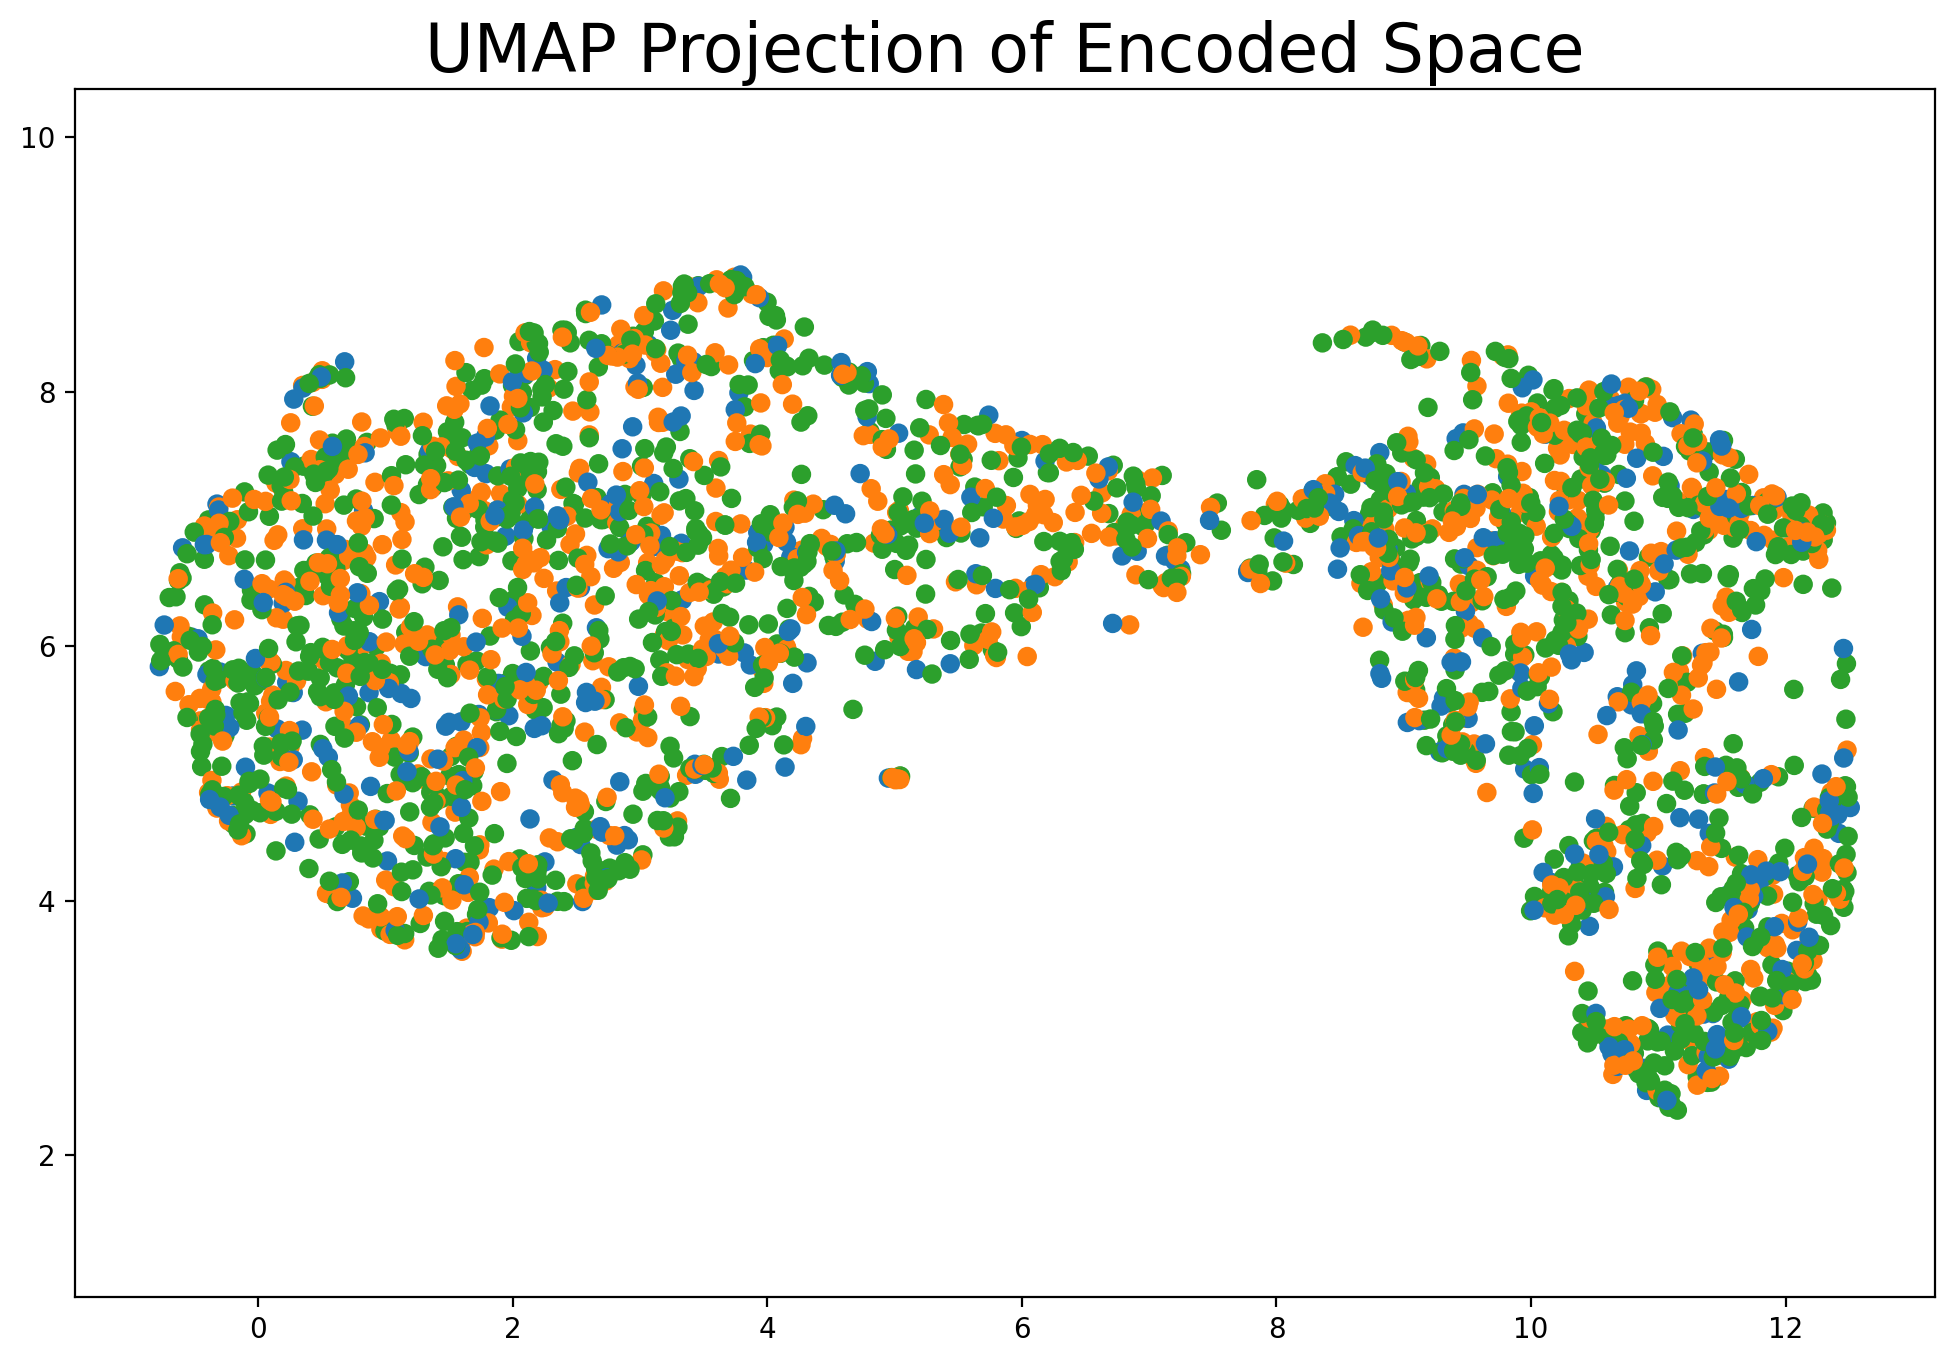

In [36]:
siamese_learner.summary()

In [ ]:
siamese_learner.unfreeze()
siamese_learner.fit(n_epoch=10, lr=10e-5)

epoch,train_loss,valid_loss,time
0,107.795883,83.664200,14:35
1,61.032063,56.547798,14:40
2,42.672791,36.064655,14:51
3,33.016598,27.391277,14:50
4,21.827986,17.977619,14:49
5,18.607952,16.129074,14:12


Better model found at epoch 0 with valid_loss value: 83.66419982910156.
Better model found at epoch 1 with valid_loss value: 56.54779815673828.
Better model found at epoch 2 with valid_loss value: 36.06465530395508.
Better model found at epoch 3 with valid_loss value: 27.391277313232422.
Better model found at epoch 4 with valid_loss value: 17.977619171142578.
Better model found at epoch 5 with valid_loss value: 16.129074096679688.


In [ ]:
siamese_learner.fit(n_epoch=10, lr=10e-5)

In [ ]:
siamese_learner.fit(n_epoch=5, lr=10e-6)

In [ ]:
siamese_learner.fit(n_epoch=10, lr=10e-7)

In [ ]:
# siamese_learner.unfreeze()
# siamese_learner.fit(n_epoch=3, lr=10e-4)

In [ ]:
# tsne = np.load("tsne_1625777058_0.npy")